In [1]:
!pip install pytorch-pretrained-bert

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
sharedGFolderPath = "/content/gdrive/My Drive/TUM/NLP Lab/Colab Notebooks/"

In [0]:
from __future__ import absolute_import, division, print_function

import argparse
import csv
import logging
import os
import random
import sys

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from torch.nn import CrossEntropyLoss, MSELoss
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import matthews_corrcoef, f1_score

import pandas as pd

from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE, WEIGHTS_NAME, CONFIG_NAME
from pytorch_pretrained_bert.modeling import BertForSequenceClassification, BertConfig
from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule

logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""BERT finetuning runner."""

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines
        
    @classmethod
    def _read_csv(cls, input_file, quotechar=None):
        df = pd.read_csv(input_file,sep='|')
        relevantDf = df[df.Domain_Relevance == 9]
        relevantDf['AspectSentiment'] = relevantDf['Coarse_Entity'] + '-' + relevantDf['Coarse_Attribute'] + '-' + relevantDf['Sentiment']
        sentences = relevantDf['Sentence'].values.tolist()
        aspectSentiment = relevantDf['AspectSentiment'].values.tolist()
        return [sentences,aspectSentiment]
    
    @classmethod
    def _read_csv_augmented(cls, input_file, quotechar=None):
        df = pd.read_csv(input_file,sep='|')
        relevantDf = df[df.Domain_Relevance == 9]
        relevantDf['AspectSentiment'] = relevantDf['Coarse_Entity'] + '-' + relevantDf['Coarse_Attribute'] + '-' + relevantDf['Sentiment']
        sentences = relevantDf['Sentence'].values.tolist()
        aspectSentiment = relevantDf['AspectSentiment'].values.tolist()
        sentences, aspectSentiment = augmentationRound(sentences, aspectSentiment)
        return [sentences,aspectSentiment]
    
    @classmethod
    def _read_csv_augmented_from_file(cls, input_path, quotechar=None):
        df = pd.read_csv(input_path+"dataframePreProcessed.csv",sep='|')
        relevantDf = df[df.Domain_Relevance == 9]
        relevantDf['AspectSentiment'] = relevantDf['Coarse_Entity'] + '-' + relevantDf['Coarse_Attribute'] + '-' + relevantDf['Sentiment']
        sentences = relevantDf['Sentence'].values.tolist()
        aspectSentiment = relevantDf['AspectSentiment'].values.tolist()
        
        dfAugmented = pd.read_csv(input_path+"augmented.csv",sep='|')
        augmentedSentences = dfAugmented['Sentence'].values.tolist()
        augmentedAspects = dfAugmented['AspectSentiment'].values.tolist()
        
        return [sentences+augmentedSentences,aspectSentiment+augmentedAspects]

class Sst2Processor(DataProcessor):
    """Processor for the SST-2 data set (GLUE version)."""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_csv_augmented_from_file(os.path.join(data_dir, "train/")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_csv(os.path.join(data_dir, "validation/dataframePreProcessed.csv")), "validation")

    def get_labels(self):
        """See base class."""
        all_labels = []
        #entities = ['g', 'p', 'f', 'c', 'cg', 'cp', 'cf', 'cc', 'cg', 'gg']
        #attributes = ['g', 'p', 'll', 'h', 'e', 'c', 's', 'q', 'pp', 't', 'or', 'a', 'l', 'av']
        #sentiments = ['0','p','n']
        entities = ['organic', 'conventional', 'GMO']
        attributes = ['general', 'price', 'experienced quality', 'safety and healthiness', 'trustworthy sources', 'environment']
        sentiments = ['0','p','n']
        for entity in entities:
            for attribute in attributes:
                for sentiment in sentiments:
                    all_labels.append(entity+'-'+attribute+'-'+sentiment)
        return all_labels

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for i in range(len(lines[0])):
            guid = "%s-%s" % (set_type, i)
            text_a = lines[0][i]
            label = lines[1][i]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples


def convert_examples_to_features(examples, label_list, max_seq_length,
                                 tokenizer, output_mode):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {label : i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        if ex_index % 1000 == 0:
            logger.info("Writing example %d of %d" % (ex_index, len(examples)))

        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if output_mode == "classification":
            label_id = label_map[example.label]
        elif output_mode == "regression":
            label_id = float(example.label)
        else:
            raise KeyError(output_mode)

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %d)" % (example.label, label_id))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()


def simple_accuracy(preds, labels):
    return (preds == labels).mean()


def acc_and_f1(preds, labels, average='binary'):
    acc = simple_accuracy(preds, labels)
    f1 = f1_score(y_true=labels, y_pred=preds, average=average)
    return {
        "acc": acc,
        "f1": f1,
        "acc_and_f1": (acc + f1) / 2,
    }


def pearson_and_spearman(preds, labels):
    pearson_corr = pearsonr(preds, labels)[0]
    spearman_corr = spearmanr(preds, labels)[0]
    return {
        "pearson": pearson_corr,
        "spearmanr": spearman_corr,
        "corr": (pearson_corr + spearman_corr) / 2,
    }


def compute_metrics(task_name, preds, labels):
    assert len(preds) == len(labels)
    if task_name == "cola":
        return {"mcc": matthews_corrcoef(labels, preds)}
    elif task_name == "sst-2":
        return {"acc": acc_and_f1(preds, labels, 'micro')}
    elif task_name == "mrpc":
        return acc_and_f1(preds, labels)
    elif task_name == "sts-b":
        return pearson_and_spearman(preds, labels)
    elif task_name == "qqp":
        return acc_and_f1(preds, labels)
    elif task_name == "mnli":
        return {"acc": simple_accuracy(preds, labels)}
    elif task_name == "mnli-mm":
        return {"acc": simple_accuracy(preds, labels)}
    elif task_name == "qnli":
        return {"acc": simple_accuracy(preds, labels)}
    elif task_name == "rte":
        return {"acc": simple_accuracy(preds, labels)}
    elif task_name == "wnli":
        return {"acc": simple_accuracy(preds, labels)}
    else:
        raise KeyError(task_name)


In [0]:
def readConfig():
    args = argparse.Namespace()
    args.data_dir = sharedGFolderPath+'organic/annotated/data/'
    args.bert_model = 'bert-base-uncased'
    args.pretrained_bert_model = sharedGFolderPath+'organic/unannotated/unsupervisedLM/Model/bert-uncased-pretrained-organic-V03/'
    args.task_name = 'sst-2'
    args.output_dir = sharedGFolderPath+'organic/annotated/baseline/model/Current/'
    args.cache_dir = sharedGFolderPath+'organic/unannotated/unsupervisedLM/Model/cache/'
    args.max_seq_length = 32
    args.do_lower_case = True
    args.train_batch_size = 32
    args.eval_batch_size = 32
    args.learning_rate = 3e-5
    args.num_train_epochs = 4.0
    args.warmup_proportion = 0.1
    args.seed = 42
    args.gradient_accumulation_steps = 1.0
    
    return args

In [0]:
def runTraining():
    trace = []   
    args = readConfig()

    processors = {
        "sst-2": Sst2Processor
    }

    output_modes = {
        "sst-2": "classification"
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_gpu = torch.cuda.device_count()

    logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', datefmt = '%m/%d/%Y %H:%M:%S', level = logging.INFO)

    logger.info("device: {} n_gpu: {}, distributed training: {}".format(device, n_gpu, False))

    if args.gradient_accumulation_steps < 1:
        raise ValueError("Invalid gradient_accumulation_steps parameter: {}, should be >= 1".format(args.gradient_accumulation_steps))

    args.train_batch_size = args.train_batch_size // args.gradient_accumulation_steps

    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

    if os.path.exists(args.output_dir) and os.listdir(args.output_dir):
        raise ValueError("Output directory ({}) already exists and is not empty.".format(args.output_dir))
    if not os.path.exists(args.output_dir):
        os.makedirs(args.output_dir)

    task_name = args.task_name.lower()

    if task_name not in processors:
        raise ValueError("Task not found: %s" % (task_name))

    processor = processors[task_name]()
    output_mode = output_modes[task_name]

    label_list = processor.get_labels()
    num_labels = len(label_list)

    tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=args.do_lower_case)
    #tokenizer = BertTokenizer.from_pretrained(args.pretrained_bert_model, do_lower_case=args.do_lower_case)

    train_examples = None
    num_train_optimization_steps = None
    train_examples = processor.get_train_examples(args.data_dir)
    num_train_optimization_steps = int(
        len(train_examples) / args.train_batch_size / args.gradient_accumulation_steps) * args.num_train_epochs

    # Prepare model
    cache_dir = args.cache_dir if args.cache_dir else os.path.join(str(PYTORCH_PRETRAINED_BERT_CACHE))
    model = BertForSequenceClassification.from_pretrained(args.bert_model,cache_dir=cache_dir,num_labels=num_labels)
    #model = BertForSequenceClassification.from_pretrained(args.pretrained_bert_model,cache_dir=cache_dir,num_labels=num_labels)
    
    model.to(device)
    if n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Prepare optimizer
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = BertAdam(optimizer_grouped_parameters, lr=args.learning_rate, warmup=args.warmup_proportion, t_total=num_train_optimization_steps)

    global_step = 0
    nb_tr_steps = 0
    tr_loss = 0
    
    train_features = convert_examples_to_features(
        train_examples, label_list, args.max_seq_length, tokenizer, output_mode)
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_examples))
    logger.info("  Batch size = %d", args.train_batch_size)
    logger.info("  Num steps = %d", num_train_optimization_steps)
    all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)

    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.float)

    train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=int(args.train_batch_size))

    model.train()
    for epochCount in trange(int(args.num_train_epochs), desc="Epoch"):
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        trainIterator = tqdm(train_dataloader, desc="Iteration")
        for step, batch in enumerate(trainIterator):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids = batch

            # define a new function to compute loss values for both output_modes
            logits = model(input_ids, segment_ids, input_mask, labels=None)

            if output_mode == "classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
            elif output_mode == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), label_ids.view(-1))

            if n_gpu > 1:
                loss = loss.mean() # mean() to average on multi-gpu.
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            loss.backward()

            trainIterator.set_postfix(loss=loss.item())
            trace.append((global_step,loss.item()))

            tr_loss += loss.item()
            nb_tr_examples += input_ids.size(0)
            nb_tr_steps += 1
            if (step + 1) % args.gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
                global_step += 1

    # Save a trained model, configuration and tokenizer
    model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self

    # If we save using the predefined names, we can load using `from_pretrained`
    output_model_file = os.path.join(args.output_dir, WEIGHTS_NAME)
    output_config_file = os.path.join(args.output_dir, CONFIG_NAME)

    torch.save(model_to_save.state_dict(), output_model_file)
    model_to_save.config.to_json_file(output_config_file)
    tokenizer.save_vocabulary(args.output_dir)
    
    return trace

In [0]:
def runTest():
    args = readConfig()

    processors = {
        "sst-2": Sst2Processor
    }

    output_modes = {
        "sst-2": "classification"
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_gpu = torch.cuda.device_count()

    logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', datefmt = '%m/%d/%Y %H:%M:%S', level = logging.INFO)

    logger.info("device: {} n_gpu: {}, distributed training: {}".format(device, n_gpu, False))
    
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)
        
    task_name = args.task_name.lower()

    if task_name not in processors:
        raise ValueError("Task not found: %s" % (task_name))

    processor = processors[task_name]()
    output_mode = output_modes[task_name]

    label_list = processor.get_labels()
    num_labels = len(label_list)
    
    # Load a trained model and vocabulary that you have fine-tuned
    model = BertForSequenceClassification.from_pretrained(args.output_dir, num_labels=num_labels)
    tokenizer = BertTokenizer.from_pretrained(args.output_dir, do_lower_case=args.do_lower_case)
    model.to(device)

    eval_examples = processor.get_dev_examples(args.data_dir)
    eval_features = convert_examples_to_features(eval_examples, label_list, args.max_seq_length, tokenizer, output_mode)
    logger.info("***** Running evaluation *****")
    logger.info("  Num examples = %d", len(eval_examples))
    logger.info("  Batch size = %d", args.eval_batch_size)
    all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)

    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.float)

    eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    # Run prediction for full data
    eval_sampler = SequentialSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args.eval_batch_size)

    model.eval()
    eval_loss = 0
    nb_eval_steps = 0
    preds = []

    for input_ids, input_mask, segment_ids, label_ids in tqdm(eval_dataloader, desc="Evaluating"):
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)
        label_ids = label_ids.to(device)

        with torch.no_grad():
            logits = model(input_ids, segment_ids, input_mask, labels=None)

            # create eval loss and other metric required by the task
        if output_mode == "classification":
            loss_fct = CrossEntropyLoss()
            tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
        elif output_mode == "regression":
            loss_fct = MSELoss()
            tmp_eval_loss = loss_fct(logits.view(-1), label_ids.view(-1))

        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if len(preds) == 0:
            preds.append(logits.detach().cpu().numpy())
        else:
            preds[0] = np.append(preds[0], logits.detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    preds = preds[0]
    if output_mode == "classification":
        preds = np.argmax(preds, axis=1)
    elif output_mode == "regression":
        preds = np.squeeze(preds)
    result = compute_metrics(task_name, preds, all_label_ids.numpy())

    result['eval_loss'] = eval_loss

    output_eval_file = os.path.join(args.output_dir, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results *****")
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

In [9]:
trace = runTraining()

06/16/2019 22:53:55 - INFO - __main__ -   device: cuda n_gpu: 1, distributed training: False
06/16/2019 22:53:55 - INFO - pytorch_pretrained_bert.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache, downloading to /tmp/tmpjf51mf2n
100%|██████████| 231508/231508 [00:00<00:00, 2577886.09B/s]
06/16/2019 22:53:55 - INFO - pytorch_pretrained_bert.file_utils -   copying /tmp/tmpjf51mf2n to cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
06/16/2019 22:53:55 - INFO - pytorch_pretrained_bert.file_utils -   creating metadata file for /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
06/16/2019 22:53:55 - INFO - pytorch_pretrained_bert.file_utils -   removing temp file /tmp/tmpjf51mf2n
06/16/2019 22:53:55 -

In [0]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

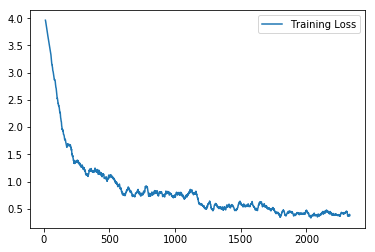

In [11]:
loss=[]
n =[]
for item in trace:
    n.append(item[0])
    loss.append(item[1])
n = running_mean(n,25)
loss = running_mean(loss,25)
plt.plot(n,loss,label='Training Loss')
plt.legend()
plt.show()

In [12]:
runTest()

06/16/2019 23:11:46 - INFO - __main__ -   device: cuda n_gpu: 1, distributed training: False
06/16/2019 23:11:46 - INFO - pytorch_pretrained_bert.modeling -   loading archive file /content/gdrive/My Drive/TUM/NLP Lab/Colab Notebooks/organic/annotated/baseline/model/Current/
06/16/2019 23:11:46 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

06/16/2019 23:11:49 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file /content/gdrive/My Drive/TUM/NLP Lab/Colab Notebooks/organic/annotated/baseline/model/Current/vocab.txt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s